In [1]:
import os 
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
DATADIR = 'D:\\data\\temps\\'
todo = OrderedDict([
       ('NASA GISTEMP', 'giss_anom.csv'),
       ('NOAA NCDC', 'ncdc_anom.csv'),
       ('HadCRU', 'hadcru_anom.csv'),
       ('RSS', 'rss_anom.csv'),
       ('UAH', 'uah_anom.csv')
        ])

In [3]:
'''
As all have different baseline climate periods, need to 1st set all to a common baseline
As satellite records are only 1979+, use only 1979-2016 data
'''

offsets = {} # we'll use UAH 1981-2011 baseline as zero point
annual_means = OrderedDict()

for key, val in todo.iteritems():
    data = pd.read_csv(os.path.join(DATADIR,val))
    #calc offsets from UAH baseline
    subset_offset = np.logical_and(1981 <= data['year'], data['year'] < 2011)
    offset_use = data[subset_offset]

    if offset_use.shape[-1 ] > 3: # deal with giss data
        offsets[key] = offset_use[offset_use.keys()[1:]].as_matrix().mean()        
    else:
        offsets[key] = offset_use['val'].mean()
        
    #get annual means for each dataset
    #subset_same = 1979 <= data['year'] #need the same period for all data
    subset_same = np.logical_and(1979 <= data['year'], data['year'] < 2017)
    same_use = data[subset_same]
    
    if same_use.shape[-1 ] > 3: # deal with giss data
        ts = same_use[offset_use.keys()[1:]].as_matrix()
        annual_means[key] = np.average(ts, axis=1) 
    else:
        ts = same_use['val'].reshape(-1,12)
        annual_means[key] = np.average(ts,axis=1)
          
print offsets # UAH is virtually 0, as should be expected

{'UAH': -2.2222222222222318e-05, 'NOAA NCDC': 0.43363888888888885, 'HadCRU': 0.2929888888888888, 'NASA GISTEMP': 0.43036111111111103, 'RSS': 0.09735000000000003}


In [6]:
x = np.arange(1979,2016+1)

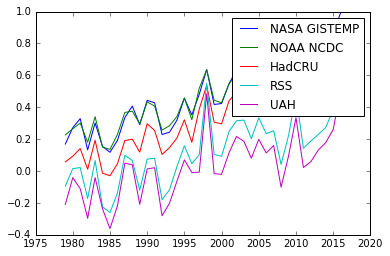

In [112]:
# can see that series follow same general pattern but are offset in Y due to having different baselines
for key, val in annual_means.iteritems():
    plt.plot(x, val, label=key)
    plt.legend()
plt.show()

In [5]:
#let's fix that
annual_means_fixed = OrderedDict()

for key, val in annual_means.iteritems():
    annual_means_fixed[key] = val - offsets[key]

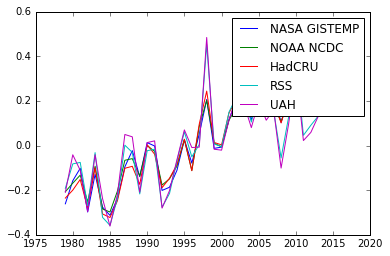

In [113]:
#works!
for key, val in annual_means_fixed.iteritems():
    plt.plot(x,val, label=key)
    plt.legend()
plt.show()

In [7]:
'''
fit linear models to data
want to have standard error estimate of fitted slopes BUT temp data is autocorrelated = too small errors
correct SE by estimating effective degrees of freedom via Foster and Rahmstorf (2011)
'''

from scipy.stats import linregress
from statsmodels.regression import yule_walker

In [8]:
reg = OrderedDict()
for key, val in annual_means_fixed.iteritems():
    m,c,r,p,se = linregress(x,val)
    fit = m*x + c
    
    residual = val - fit
    p1,p2 = yule_walker(residual, 2)[0]
    fi = p2/p1
    v = 1+(2*p1)/1-fi
    se_corr = se*np.sqrt(v)    
    reg[key] = (fit,m,se_corr)
    print key,se,se_corr

NASA GISTEMP 0.00138505155534 0.002127298429
NOAA NCDC 0.00125873315907 0.00196379426504
HadCRU 0.00135777588192 0.00208578415228
RSS 0.00205889424589 0.00368544973049
UAH 0.0021552853948 0.00582293899485


In [105]:
#now let's make an interactive chart
from bokeh import plotting as bplt
from bokeh.models import HoverTool, ColumnDataSource, CheckboxGroup, CustomJS
from bokeh.layouts import row,column
from bokeh.io import output_file

In [108]:
colours = dict((key,val) for key,val in zip(annual_means_fixed.keys(), ['black', 'red', 'blue', 'yellow', 'orange']))
out = os.path.join(DATADIR,'test.html')
output_file(out)

In [109]:
plot = bplt.figure(
            tools="pan,box_zoom,reset,resize,save,crosshair,hover",
            x_axis_label='Година',
            y_axis_label ='Градуси (°C)',
            toolbar_location = 'right',
            width= 800,
            height = 400)

hover = plot.select(dict(type=HoverTool))
hover.tooltips = OrderedDict([('Година', '@year'), ('Отклонение', '@anomaly{1.11}'), ('Източник', '@source')])
hover.names = ['scatter']
hover.point_policy='snap_to_data'

props = []
for key,val in annual_means_fixed.iteritems():
    to_plot = ColumnDataSource({'year': x, 'anomaly': val, 'source': np.repeat(key, len(x))})
    p1=plot.line(x,val, line_color = colours[key],legend=key)
    p2=plot.circle('year', 'anomaly', source=to_plot, legend=key, name='scatter', fill_color = colours[key], size = 8)
    
    p3=plot.line(x,reg[key][0], line_color = colours[key], line_width = 2, line_dash='dashed')
    
    props.append((p1,p2,p3))
    
plot.legend.location = "top_left" 

checkbox = CheckboxGroup(labels=annual_means_fixed.keys(),
                         active=[0,1,2,3,4], width=100)

callback_arg = dict(p00=props[0][0],p01=props[0][1],p02=props[0][2],
                    p10=props[1][0],p11=props[1][1],p12=props[1][2],
                    p20=props[2][0],p21=props[2][1],p22=props[2][2],
                    p30=props[3][0],p31=props[3][1],p32=props[3][2],
                    p40=props[4][0],p41=props[4][1],p42=props[4][2],
                    checkbox=checkbox)

#https://github.com/bokeh/bokeh/issues/5743
checkbox.callback = CustomJS(args=callback_arg,
                             code="""
var indexOf = [].indexOf || function(item) { for (var i = 0, l = this.length; i < l; i++) { if (i in this && this[i] === item) return i; } return -1; };                             
p00.visible = indexOf.call(checkbox.active,0)>=0;
p01.visible = indexOf.call(checkbox.active,0)>=0;
p02.visible = indexOf.call(checkbox.active,0)>=0;
p10.visible = indexOf.call(checkbox.active,1)>=0;
p11.visible = indexOf.call(checkbox.active,1)>=0;
p12.visible = indexOf.call(checkbox.active,1)>=0;
p20.visible = indexOf.call(checkbox.active,2)>=0;
p21.visible = indexOf.call(checkbox.active,2)>=0;
p22.visible = indexOf.call(checkbox.active,2)>=0;
p30.visible = indexOf.call(checkbox.active,3)>=0;
p31.visible = indexOf.call(checkbox.active,3)>=0;
p32.visible = indexOf.call(checkbox.active,3)>=0;
p40.visible = indexOf.call(checkbox.active,4)>=0;
p41.visible = indexOf.call(checkbox.active,4)>=0;
p42.visible = indexOf.call(checkbox.active,4)>=0;
""")

layout = row(plot,checkbox)
plot.xaxis.axis_label_text_font_size = "12pt"
plot.yaxis.axis_label_text_font_size = "12pt"
plot.xaxis.axis_label_text_font_style = 'normal'
plot.yaxis.axis_label_text_font_style = 'normal'
plot.xaxis.major_label_text_font_size = '12pt'
plot.yaxis.major_label_text_font_size = '12pt'
#bplt.output_notebook()

bplt.show(layout)

In [77]:
#plot the slopes of the regression lines +-95%CI
xi = np.arange(0,5)
y = []
yerr = []
for k,v in reg.iteritems():
    print k, v[1]*10, v[2]*10 #per decade
    y.append(v[1]*10)
    yerr.append(1*v[2]*10)
    
plt.errorbar(xi,y,yerr=yerr, fmt='ko',linewidth=1,capsize=5)
ax = plt.gca()

for xx,yy,ye in zip(xi, y, yerr):      
    pass
    annotation = r'{}$\pm${}'.format(np.round(yy,2), np.round(ye,2))
    ax.annotate(annotation,(xx,yy), textcoords='data', xytext = (xx+0.05,yy+0.001))

ax.set_xticklabels(np.concatenate([np.array(['']),reg.keys()]), size=12, rotation=12)
plt.xlim(-1,5)
ylabel = r'$\circ$C'
ax.set_ylabel(ylabel)
plt.savefig(os.path.join(DATADIR, 'slopes.png'), transparent=True)

NASA GISTEMP 0.172666593719 0.02127298429
NOAA NCDC 0.163069445964 0.0196379426504
HadCRU 0.171932012985 0.0208578415228
RSS 0.135174718241 0.0368544973049
UAH 0.123268136558 0.0582293899485


In [30]:
'''
can see that slopes are not significantly different visually
just in case, run GLM w/ dummy interaction (i.e. ANCOVA) to test 
'''
from statsmodels.formula.api import ols

In [50]:
t = np.repeat(x,5)
d = np.concatenate([val for val in annual_means_fixed.values()])
g = np.concatenate([np.repeat(key,len(x)) for key in reg.keys()])

df = pd.DataFrame({'time':t, 'val':d, 'dataset':g})

In [62]:
formula = 'time~val*dataset' #test temp*dataset interaction term i.e. is there a diff in slopes between datasets?
lm = ols(formula, df)
lmfit = lm.fit()
print lmfit.summary()
# p>0.05 for all interactions = not significantly different from each other

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1537.
Date:                Sun, 05 Feb 2017   Prob (F-statistic):          3.90e-165
Time:                        13:58:07   Log-Likelihood:                -310.93
No. Observations:                 190   AIC:                             641.9
Df Residuals:                     180   BIC:                             674.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept         